In [2]:
from compute import Var, eqvar, ureg, get_unit, buildidpvars, coupled_run, Evaluable, args_in_order, fill_args
from inputresolver import reassigneq, eqvars, eqsonly, default_out, mdf_order, default_in, idx_eqlist, flatten_order
from inputresolver import getallvars, invert_edges, resolve, reassign
from representations import bipartite_repr, drawbipartite, digraph_repr, draw, draw_dsm
from compute_utils import get_outputs, check_eqs, print_out
from pprint import pprint
import networkx as nx
import sympy as sp
from sympy.utilities.lambdify import implemented_function
import numpy as np
from scipy import interpolate
import openmdao.api as om
import gpkit as gp
import cvxpy as cp

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

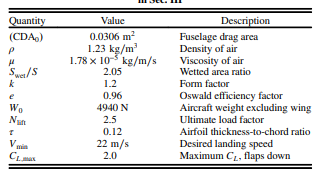

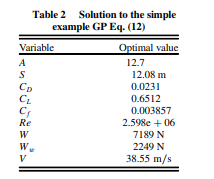

# GP model (cvxpy)

In [8]:
rho = 1.23
mu = 1.78e-5
SwetS = 2.05
k = 1.2
t = 0.12
e = 0.96
N = 2.5
CDA = 0.0306
W0 = 4940
rhoS = 45.42
#Vmin = gp.Variable('Vmin', 22, 'm/s')

A = cp.Variable(pos=True)
V = cp.Variable(pos=True)
S = cp.Variable(pos=True)
Re = cp.Variable(pos=True)
Cf = cp.Variable(pos=True)
CL = cp.Variable(pos=True)
CD = cp.Variable(pos=True)
D = cp.Variable(pos=True)
W = cp.Variable(pos=True)
Ww = cp.Variable(pos=True)
Dmin = 1000

f1 = Re == rho*V/mu*(S/A)**(1/2)
f2 = Cf == 0.074/Re**0.2
f3 = CD >= CDA/S+k*Cf*SwetS+CL**2/(np.pi*A*e)
f4 = D == 0.5*rho*V**2*CD*S
f5 = Ww >= rhoS*S+8.71e-5*N/t*A**(3/2)*S**(1/2)*(W0*W)**(1/2)
f6 = W >= W0+Ww
f7 = CL == 2*W/(rho*V**2*S)
#f8 = 2.2 >= 2*W/(rho*Vmin**2*S)

In [9]:
constraints= [f1, f2, f3, f4, f5, f6, f7]
m = cp.Problem(cp.Minimize(D), [f1, f2, f3, f4, f5, f6, f7])
m.solve(gp=True, verbose=True)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Oct 18 10:47:55 AM: Your problem has 10.0 variables, 7 constraints, and 0 parameters.
(CVXPY) Oct 18 10:47:55 AM: It is compliant with the following grammars: DGP
(CVXPY) Oct 18 10:47:55 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 18 10:47:55 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 18 10:47:55 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 18 10:47:55 AM: Reduction chain: Dgp2Dcp -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStu

242.2747822020913

In [4]:
A.value, S.value, V.value

(18.16404007821608, 5.255019970282748, 49.18171275809488)

## MDF

In [2]:
rho = Var('rho', 1.23, 'kg/m^3', never_output=True)
mu = Var('mu', 1.78e-5, 'kg/m/s', never_output=True)
SwetS = Var('SwetS', 2.05, never_output=True)
k = Var('k', 1.2, never_output=True)
t = Var('t', 0.12, 'm', never_output=True)
e = Var('e', 0.96, never_output=True)
N = Var('N', 2.5, never_output=True)
CDA = Var('CDA', 0.0306, 'm^2', never_output=True)
W0 = Var('W0', 4940, 'N', never_output=True)
rhoS = Var('rhoS', 45.42, 'N/m^2', never_output=True)

A = Var('A')
V = Var('V', unit='m/s')
S = Var('S', unit='m^2')
Re, f1 = eqvar('Re', rho*V/mu*(S/A)**(1/2))
Cf, f2 = eqvar('Cf', 0.074/Re**0.2, unit='', forceunit=True)
CL = Var('CL')
CD, f3 = eqvar('CD', CDA/S+k*Cf*SwetS+CL**2/(np.pi*A*e))
D, f4 = eqvar('D', 0.5*rho*V**2*CD*S)
W = Var('W', unit='N')
Ww, f5 = eqvar('Ww', rhoS*S+8.71e-5*N/t*A**(3/2)*S**(1/2)*(W0*W)**(1/2))
f6 = (W, W0+Ww)
f7 = (CL, 2*W/(rho*V**2*S))

In [3]:
eq_list = [f1,f2,f3,f4,f5,f6,f7]
eqs = idx_eqlist(eq_list)
eqv = eqvars(eqs)
dins = default_in(eqs, count_never_output=True) #includes parameters
dout = default_out(eqs)

In [4]:
eqv_noparams = {elt:{key for key in keys if not key.never_output} for elt,keys in eqv.items()}

In [5]:
DG, edges = digraph_repr(eqv_noparams, dout, intermediary=False)

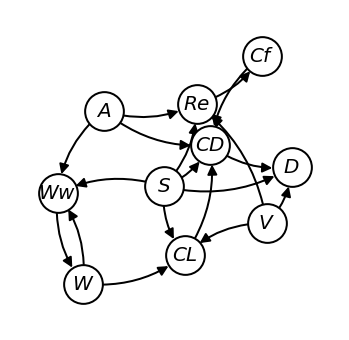

In [9]:
draw(DG, node_shape='o', node_size=1500, arc=0.2)

In [7]:
order = mdf_order(eqv, dout)

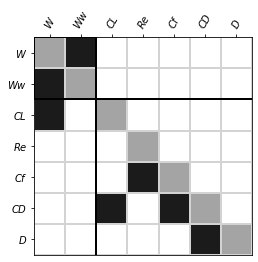

In [13]:
ax = draw_dsm(DG, flatten_order(order), dout)
rect1 = patches.Rectangle((0, 0), 2, 2, linewidth=2, edgecolor='k', facecolor='none')
#rect1.set_alpha(0.2)
rect2 = patches.Rectangle((2, 2), 7, 7, linewidth=2, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2);
plt.savefig('woodymdf.png', dpi=600)

In [4]:
eq_list

[(Re, V*rho*(S/A)**0.5/mu),
 (Cf, 0.074*Re**(-0.2)),
 (CD, CDA/S + Cf*SwetS*k + 0.318309886183791*CL**2/(A*e)),
 (D, 0.5*CD*S*V**2*rho),
 (Ww, 8.71e-5*A**1.5*N*S**0.5*(W*W0)**0.5/t + S*rhoS),
 (W, W0 + Ww),
 (CL, 2*W/(S*V**2*rho))]

In [6]:
order

[(4, 5), 6, 0, 1, 2, 3]

In [7]:
dins

{A, CDA, N, S, SwetS, V, W0, e, k, mu, rho, rhoS, t}

In [18]:
prob = om.Problem()
model = prob.model
# buildidpvars(dins | {W, Ww} , model)
# counter = coupled_run(eqs, [6, 0, 1, 2, 3], (5,4), model, model, useresiduals=True)
buildidpvars(dins, model)
counter = coupled_run(eqs, order, (), model, model)
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
# prob.model.add_design_var('W', lower=1e3, upper=1e4)
# prob.model.add_design_var('Ww', lower=1e3, upper=1e4)
#prob.model.add_subsystem('dummy', om.ExecComp('obj = 0'))
prob.model.add_design_var('A', lower=0.1, upper=50)
prob.model.add_design_var('V', lower=0.1, upper=50)
prob.model.add_design_var('S', lower=0.1, upper=50)
prob.model.add_objective('D')
#prob.model.add_objective('dummy.obj')
prob.setup()
prob.set_solver_print(level=0)
prob.set_val('A', 12)
prob.set_val('V', 40)
prob.set_val('S', 12)
prob.run_driver();
#prob.run_model()

Optimization terminated successfully    (Exit mode 0)
            Current function value: [242.27476039]
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
Optimization Complete
-----------------------------------


In [29]:
prob.model.group1.group2.eq5.iter_count

34

In [19]:
model.list_outputs();

20 Explicit Output(s) in 'model'

varname   val               
--------  ------------------
inp
  S       [5.25550216]      
  k       [1.2]             
  CDA     [0.0306]          
  rhoS    [45.42]           
  V       [49.18282355]     
  rho     [1.23]            
  N       [2.5]             
  e       [0.96]            
  W0      [4940.]           
  A       [18.1632583]      
  SwetS   [2.05]            
  t       [0.12]            
  mu      [1.78e-05]        
group1
  group2
    eq4
      Ww  [2143.57006145]   
    eq5
      W   [7083.57006145]   
  eq6
    CL    [0.90601616]      
  eq0
    Re    [1828137.24540357]
  eq1
    Cf    [0.00413838]      
  eq2
    CD    [0.03098788]      
  eq3
    D     [242.27476039]    


0 Implicit Output(s) in 'model'




In [15]:
model.list_outputs();

23 Explicit Output(s) in 'model'

varname   val               
--------  ------------------
inp
  t       [0.12]            
  V       [40.]             
  rho     [1.23]            
  N       [2.5]             
  k       [1.2]             
  e       [0.96]            
  W       [7024.26985372]   
  rhoS    [45.42]           
  Ww      [2084.26985372]   
  mu      [1.78e-05]        
  SwetS   [2.05]            
  CDA     [0.0306]          
  S       [12.]             
  W0      [4940.]           
  A       [12.]             
group1
  group2
    eq6
      CL  [0.5948738]       
    eq0
      Re  [2764044.94382023]
    eq1
      Cf  [0.00380998]      
    eq2
      CD  [0.02170049]      
    eq3
      D   [256.23938743]    
eq5
  r5      [4.54747351e-13]  
eq4
  r4      [4.54747351e-13]  
dummy
  obj     [0.]              


0 Implicit Output(s) in 'model'




In [14]:
model.list_outputs();

20 Explicit Output(s) in 'model'

varname   val               
--------  ------------------
inp
  rhoS    [45.42]           
  rho     [1.23]            
  e       [0.96]            
  S       [12.]             
  t       [0.12]            
  k       [1.2]             
  A       [12.]             
  CDA     [0.0306]          
  SwetS   [2.05]            
  N       [2.5]             
  mu      [1.78e-05]        
  V       [40.]             
  W0      [4940.]           
group1
  group2
    eq5
      W   [7024.26985372]   
    eq4
      Ww  [2084.26985372]   
  eq6
    CL    [0.5948738]       
  eq0
    Re    [2764044.94382023]
  eq1
    Cf    [0.00380998]      
  eq2
    CD    [0.02170049]      
  eq3
    D     [256.23938743]    


0 Implicit Output(s) in 'model'




In [165]:
outs = get_outputs(eqs, model)

In [166]:
outs

{mu: 1.78e-05,
 Ww: 2143.6524106356314,
 W: 7083.652410635632,
 rho: 1.23,
 CL: 0.9060217147255142,
 Cf: 0.004138390950999994,
 D: 242.2747605249787,
 k: 1.2,
 Re: 1828104.5087784836,
 S: 5.2552958763529665,
 A: 18.164008601092604,
 SwetS: 2.05,
 CDA: 0.0306,
 t: 0.12,
 N: 2.5,
 V: 49.18392392118704,
 rhoS: 45.42,
 e: 0.96,
 CD: 0.030987713857328826,
 W0: 4940.0}

In [75]:
check_eqs(eqs, outs)

{0: (1828166.6351383294, 1828166.63513833),
 1: (0.004138362823732449, 0.00413836282373245),
 2: (0.03098730227757834, 0.0309873022775783),
 3: (242.2747603987664, 242.274760398766),
 4: (2143.537966630028, 2143.53796663003),
 5: (7083.537966630029, 7083.53796663003),
 6: (0.905995043831173, 0.905995043831173)}